# Прогнозирование оттока клиентов в телекоммуникационной компании

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

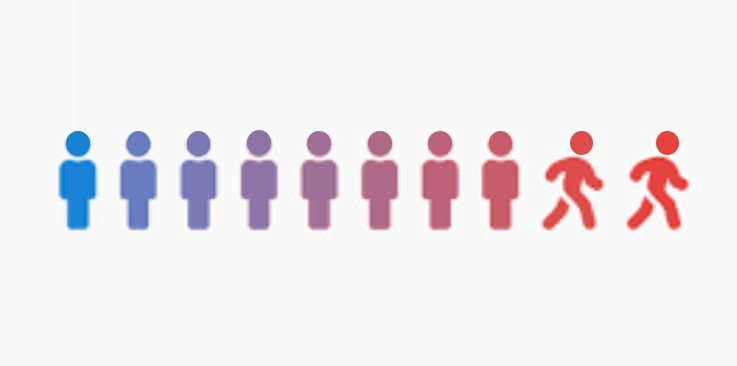

__Бизнес цель проекта:__ разработка модели прогнозирование отток клиетов для повышения лояльности клиентов и повышения общей прибыли компании.

__Нам предоставлены следующие исходные данные:__
- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – безналичный расчет,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги,
- Dependents – наличие иждивенцев,
- Senior Citizen – наличие пенсионного статуса по возрасту,
- Partner – наличие супруга(и),
- MultipleLines – наличие возможности ведения параллельных линий во время звонка.

__Цель проекта с точки зрения машинного обучения__: для решения задачи классификации несбалансированных классо внеобходимо выбрать модель машинного обучения и гиперпараметры модели максимацизирующие AUC-ROC.

__Критерии оценки качетва разарботанной модели:__
- 0 sp - 	      __AUC-ROC < 0.75__
- 4 sp -  	       __0.75 ≤ AUC-ROC < 0.81__
- 4.5 sp -         __0.81 ≤ AUC-ROC < 0.85__
- 5 sp -          __0.85 ≤ AUC-ROC < 0.87__
- 5.5 sp -         __0.87 ≤ AUC-ROC < 0.88__
- 6 sp -  	       __AUC-ROC ≥ 0.88__



__План решения задачи машинного обучения:__
1) Исследовательский анализ данных
- первоначальное изучение данных: проверка пропусков, дубликатов, типа колонок;
- расчет корреляции между признаками и признаками и целевой переменной;
- статистический анализ данных и визуализация.

2)Переработка данных и подготовка для работы моделей:
- изменение типа данных в необходимых случаях;
- замена пропусков;
- создание дополнительных признаков;
- разделение данных на тренировочные и тестовые;
- масштабирование.

3) Обучение модели:
- обучение примитивной модели в качестве порога для сравнения обученных моделей;
- построение модели логистической регрессии;
- Logistic Regression
- LightGBM
- СatBoost


4) Анализ результатов работы моделей.

5) Предложения по использованию модели для решения бизнес-задач


## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import warnings

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, plot_confusion_matrix, roc_curve, classification_report
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.preprocessing import StandardScaler 
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier
import lightgbm
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
RND =12345

### Первоначальное изучение данных

In [5]:
df = pd.read_csv('/datasets/final_provider/contract.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_pers = pd.read_csv('/datasets/final_provider/personal.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

Так целевой признак является факт ухода клиента, то ключевым признаком является EndDate - первое число месяца следующего за месяцем ухода клиента. Если эта дата отсутствует, то считаем, что клиент продолжает пользоваться услугами. Исходя из этого, нам нет смысла рассматривать пользователей, для которых нет данных в таблице contract.csv и пользователей, для которых нет данных в EndDate. Поэтому объединим все таблицы по идентификатору пользователей на основе Left Join.

In [6]:
df = df.merge(df_internet, how='left', on='customerID')\
    .merge(df_pers, how='left', on='customerID').\
     merge(df_phone, how='left', on='customerID')


In [7]:
df.head()


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [8]:
A = set(df_internet['customerID']) | set(df_phone['customerID'])
len( set(df['customerID']) - A )

0

In [9]:
len(set(df_internet['customerID']) & set(df_phone['customerID']))

4835

In [10]:
len(set(df_internet['customerID']))

5517

In [11]:
len(df_phone['customerID'])

6361

Уникальных пользователей интернета - 5517.
Уникальных пользователей телефонии - 6361.
Уникальных пользователей обоих услуг одновременно - 4835.
Пользователей которые не пользовались ни одной услугой - 0. 

In [12]:
4835/7043 

0.686497231293483

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [14]:
na_values = []
for col in df.columns:
    na_values.append(df[df[col].isnull()].shape[0])
print('Количество пропущенных значений по каждаму показателю:')
pd.DataFrame({'Имя колонки':df.columns, 
              'Количество пропущеных значений': na_values,
              'Количество посчитаных значений': df.shape[0] - np.array(na_values)}) \
            .sort_values('Количество пропущеных значений', ascending=False)   


Количество пропущенных значений по каждаму показателю:


,Имя колонки,Количество пропущеных значений,Количество посчитаных значений
10,OnlineBackup,1526,5517
8,InternetService,1526,5517
14,StreamingMovies,1526,5517
13,StreamingTV,1526,5517
12,TechSupport,1526,5517
11,DeviceProtection,1526,5517
9,OnlineSecurity,1526,5517
19,MultipleLines,682,6361
7,TotalCharges,0,7043
6,MonthlyCharges,0,7043


In [15]:
col_cat = [ 'Type', 'PaperlessBilling',
       'PaymentMethod',  'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines']

for it in col_cat:
     print(f'{it:20} {df[it].value_counts().to_dict()}' )


Type                 {'Month-to-month': 3875, 'Two year': 1695, 'One year': 1473}
PaperlessBilling     {'Yes': 4171, 'No': 2872}
PaymentMethod        {'Electronic check': 2365, 'Mailed check': 1612, 'Bank transfer (automatic)': 1544, 'Credit card (automatic)': 1522}
InternetService      {'Fiber optic': 3096, 'DSL': 2421}
OnlineSecurity       {'No': 3498, 'Yes': 2019}
OnlineBackup         {'No': 3088, 'Yes': 2429}
DeviceProtection     {'No': 3095, 'Yes': 2422}
TechSupport          {'No': 3473, 'Yes': 2044}
StreamingTV          {'No': 2810, 'Yes': 2707}
StreamingMovies      {'No': 2785, 'Yes': 2732}
gender               {'Male': 3555, 'Female': 3488}
SeniorCitizen        {0: 5901, 1: 1142}
Partner              {'No': 3641, 'Yes': 3402}
Dependents           {'No': 4933, 'Yes': 2110}
MultipleLines        {'No': 3390, 'Yes': 2971}


Практически все колонки являются категориальные. Множество значений ограничено 2-4.


In [16]:
 print('Процента данных без пропусов:',
       round(100*df.dropna()['EndDate'].count() / df['EndDate'].count(),1),'%')
    

Процента данных без пропусов: 68.6 %


У нас имеются данные на 7043 клиента. Некоторые признаки имеют тип object, что связано с особенностями неторных значений ячеек. Проведем анализ признаков:
- customerID - важный признак, позволяющий идентифицировать пользователи;
- BeginDate, EndDate -признаки, содержащие информацию о датах. __На основе признака EndDate - необходимо получить целевой признак__;
- MonthlyCharges, TotalCharges - числовые признаки;
- Все остальные признаки являются категориальные.

В итоговой объединенной таблице имеются пропуски: 
- исходная таблица по услуге стационарного интернета содержала далеко не всех пользователей, что привело к появлению пропусков в таких признаках как: InternetService,	OnlineSecurity,	OnlineBackup,	DeviceProtection,	TechSupport,	StreamingTV,	StreamingMovies.
- также имеются пропуски по признаку MultipleLines.

Данные без пропусков составляют 2/3. Данные с пропусками составляют 1/3  -  это значительная часть, поэтому проанализируем возможности по заполнению пропусков.


In [17]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce') 
df['TotalCharges'].isna().sum()

11

In [18]:
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'],errors='coerce') 
df['MonthlyCharges'].isna().sum()

0

Произвели удаление части данных, для которых отсутствует значения поля TotalCharges - общая сумма денег, потраченных на услуги связи.
Аналогично для MonthlyCharges.

In [19]:
df = df.dropna(subset=['TotalCharges'])

In [20]:
df['EndDate'].value_counts(normalize= True)*100

No                     73.421502
2019-11-01 00:00:00     6.897042
2019-12-01 00:00:00     6.626849
2020-01-01 00:00:00     6.541524
2019-10-01 00:00:00     6.513083
Name: EndDate, dtype: float64

Важный показатель EndDate позволяет определить уход клиента. Видно, что пользователи уходили группами около 6 процентов за раз. Одинаковая дата ухода может говорить о том, что плана вносится ежемесячно и некоторые пользователи просто не внесли оплату за следующий месяц и отказались от услуг связи.

In [21]:
df[(df['EndDate'] == 'No') & (~df['MultipleLines'].isna())]['customerID'].count()

4653

In [22]:
df[(df['EndDate'] != 'No') & (~df['MultipleLines'].isna())]['customerID'].count()

1699

In [23]:
df[(df['EndDate'] != 'No') & (~df['InternetService'].isna())]['customerID'].count()

1756

In [24]:
df[(df['EndDate'] == 'No') & (~df['InternetService'].isna())]['customerID'].count()

3756

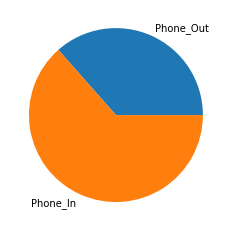

In [25]:
y = np.array([1699, 4653-1699])
mylabels = ["Phone_Out", "Phone_In"]

plt.pie(y, labels = mylabels)
plt.show() 


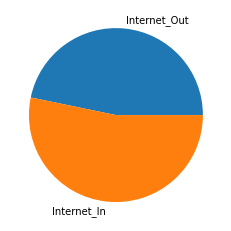

In [26]:
y = np.array([1756, 3756-1756])
mylabels = ["Internet_Out", "Internet_In"]

plt.pie(y, labels = mylabels)
plt.show() 


In [27]:
1699/(4653)

0.3651407693960885

Из сравнения графиков можно сделать вывод, что среди пользователей интернет процент оттока клиентов выше и достигает 46 %. А среди пользователей телефонии 36 %. При этом часть клиентов пользовалась как услугами интернет, так и телефонии, поэтому процент оттока клиента по обоим услугами 27 %.

In [28]:
df_no = df[df['EndDate'] == 'No']['MonthlyCharges'].describe()

In [29]:
df_yes = df[df['EndDate'] != 'No']['MonthlyCharges'].describe()

In [30]:
df_stat = pd.DataFrame({"Out":df_yes,
                        "In": df_no})

In [31]:
df_stat

,Out,In
count,1869.000000,5163.000000
mean,74.441332,61.307408
std,24.666053,31.094557
min,18.850000,18.250000
25%,56.150000,25.100000
50%,79.650000,64.450000
75%,94.200000,88.475000
max,118.350000,118.750000


На основе сравнения статистик для клиентов, которые отказались от пользования услугами (Out) и для лояльных клиентов (In) можно сделать следующие вывод: среднее значение затрат на услуги и медиана у клиентов Out выше
 

(array([783., 294.,  58., 304.,  13.,  42.,  14.,  19.,  55.,   4.,  46.,
         24.,  41., 121.,  13., 141.,  75.,  76., 157.,  37., 125.,  77.,
         63., 111.,  43., 165.,  76.,  97., 161.,  43., 184., 110.,  97.,
        152.,  54., 180.,  91.,  99., 125.,  57., 140.,  68.,  97., 116.,
         64.,  96.,  47.,  43.,  51.,  14.]),
 array([ 18.25,  20.26,  22.27,  24.28,  26.29,  28.3 ,  30.31,  32.32,
         34.33,  36.34,  38.35,  40.36,  42.37,  44.38,  46.39,  48.4 ,
         50.41,  52.42,  54.43,  56.44,  58.45,  60.46,  62.47,  64.48,
         66.49,  68.5 ,  70.51,  72.52,  74.53,  76.54,  78.55,  80.56,
         82.57,  84.58,  86.59,  88.6 ,  90.61,  92.62,  94.63,  96.64,
         98.65, 100.66, 102.67, 104.68, 106.69, 108.7 , 110.71, 112.72,
        114.73, 116.74, 118.75]),
 <BarContainer object of 50 artists>)

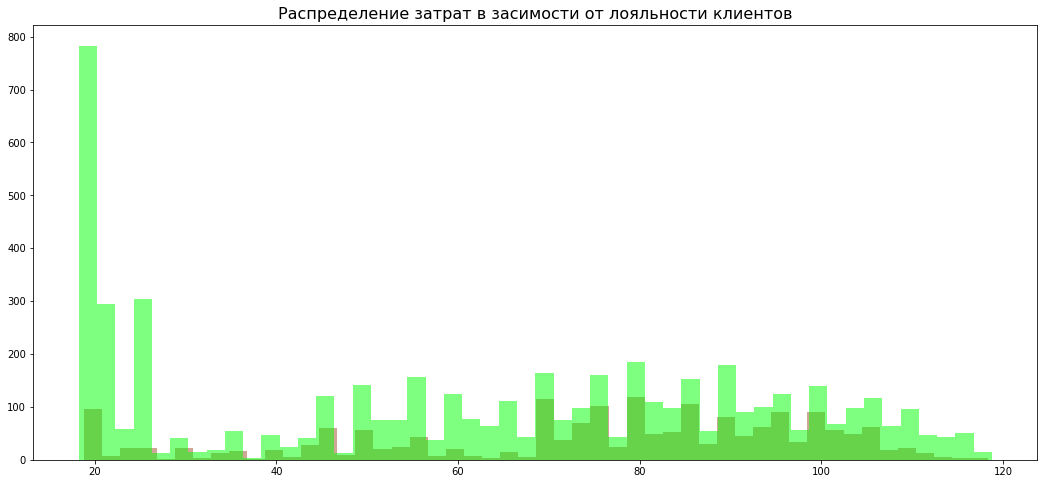

In [32]:
ALPHA = 0.5
BINS  = 50
COLORS = ['sienna', 'lime']

fig, ax1 = plt.subplots(figsize=(18,8))
ax1.set_title(f"Распределение затрат в засимости от лояльности клиентов", fontsize=16)
ax1.hist((df[df['EndDate'] != 'No']['MonthlyCharges']), color=COLORS[0], bins=BINS, alpha=ALPHA)
ax1.hist((df[df['EndDate'] == 'No']['MonthlyCharges']), color=COLORS[1], bins=BINS, alpha=ALPHA)

Из анализа графика можно сделать вывод, что у лояльных пользователей имеется пик в районе 20 у.е. в оплате услуг за месяц. В тоже время у нелояльных пользователей такого выраженного пика нет.

## Переработка данных и подготовка для работы моделей

In [33]:
df = df.fillna('No_used')

Пропуски, большей частью, связаны с тем, что только часть пользователей (68 %) пользуются одновременно обеими услугами, поэтому необходимо пометить пропуски, а не заполнять их каким-то частым значением. 

Создадим колонку с целевым признаком и признаком, определяющим длительность пользования услугами связи. Округлим время пользования услуг до месяца, что видится более честным.

In [34]:
df['BeginDate'] = df['BeginDate'].astype('datetime64')
UPLOAD_DATE = '2020-02-01'
df.loc[df['EndDate'] == 'No', 'EndDate'] = UPLOAD_DATE
df['EndDate'] = df['EndDate'].astype('datetime64')
df['begin_days'] = (pd.Timestamp(UPLOAD_DATE) - df['BeginDate']) / np.timedelta64(1, 'M')
df.drop('BeginDate', axis=1, inplace=True)
df['end_days'] = (pd.Timestamp(UPLOAD_DATE) - df['EndDate']) / np.timedelta64(1, 'M')
df.drop('EndDate', axis=1, inplace=True)
df['target'] = (df['end_days'] > 0).astype('bool')
df['lifetime'] = df['begin_days'] - df['end_days']
df.drop(['begin_days', 'end_days', 'customerID'], axis=1, inplace=True)

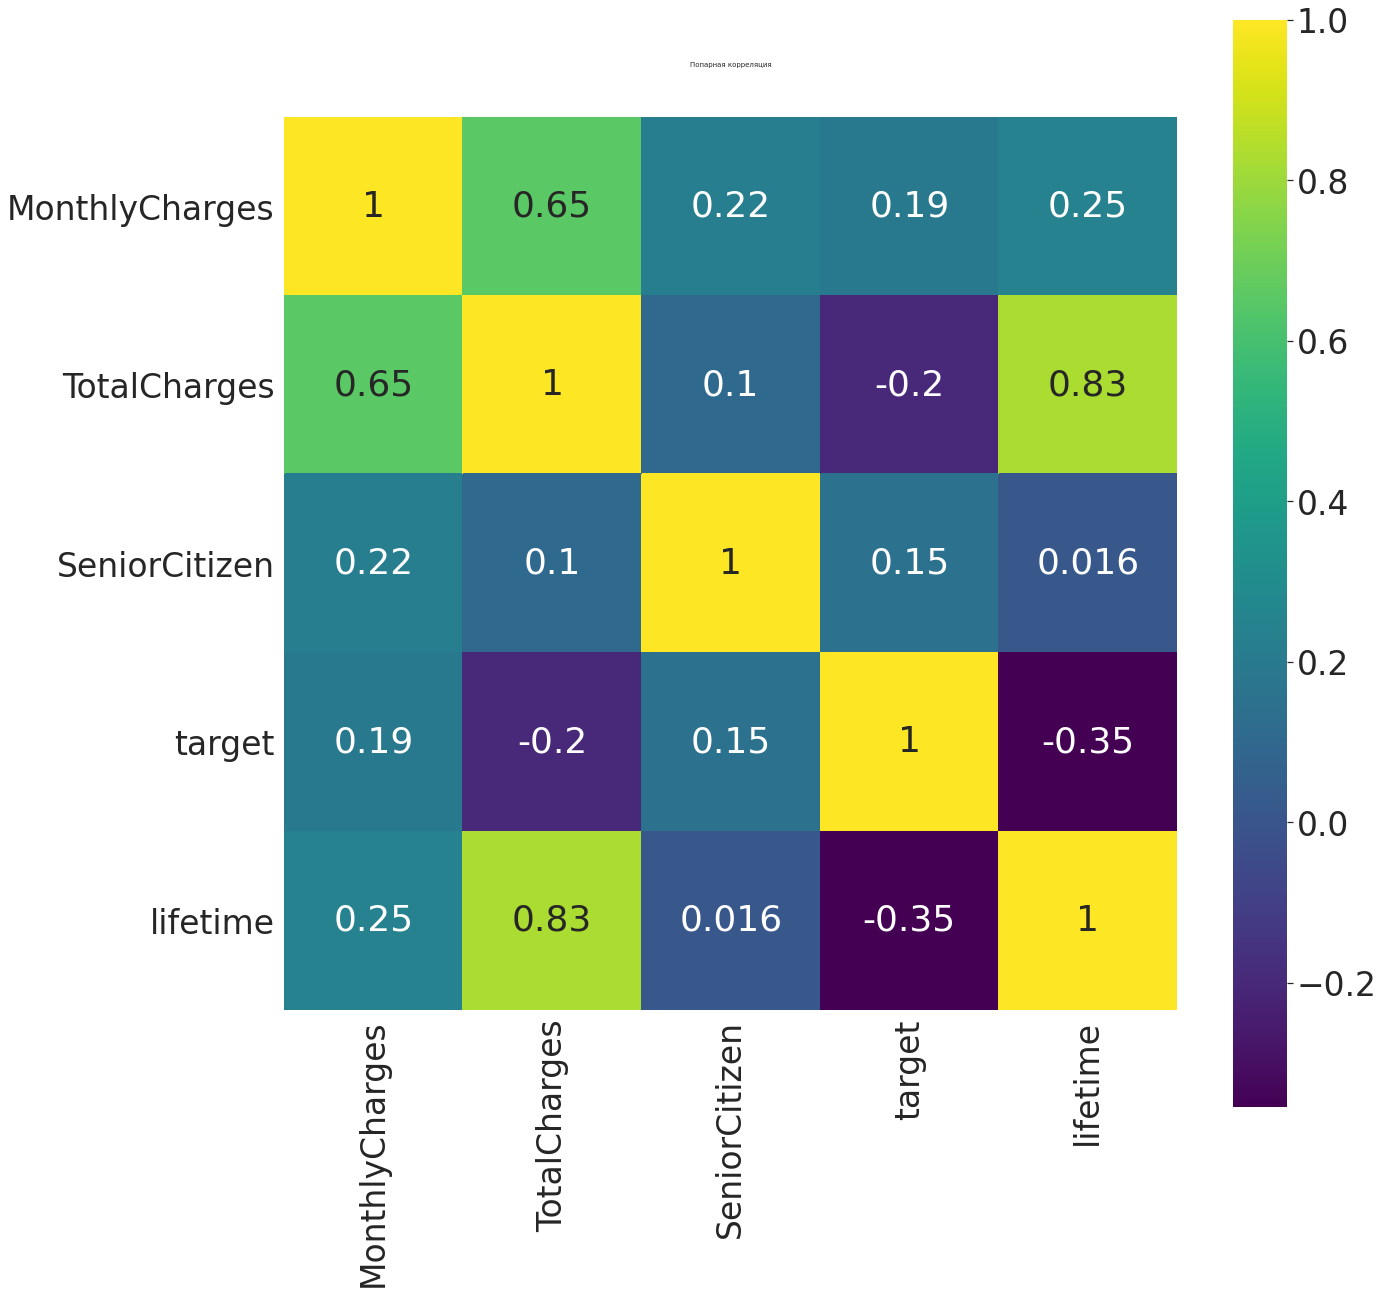

In [35]:
colormap = plt.cm.viridis
plt.figure(figsize=(20,20))
sns.set(font_scale=3)
plt.title('Попарная корреляция', y=1.05, size=7)
sns.heatmap(df.corr(), square=True, annot=True, cmap=colormap)
plt.show()

__Значимой корреляции между целевым признаком и другими признаками не выявлено.__
Имеются следующие корреляции: 
- сильная корреляция между суммарными тратами за все время пользования услугами временем пользования услугами связи, что весьма ожидаемо;
- имеется корреляция средней силы между суммарными тратами за все время пользования услугами средними тратами, что также весьма ожидаемо.





__Мы получили все признаки, теперь можно окончательно провести EDA__

В рамках нашей задачи с точки зрения бизнеса: необходимо максимизировать прибыль, т.е. продать клиенту как можно больше услуг (будем считать, что нет услуг которые имеют отрицательную рентабельность), стоимость услуг должна быть максимальная такая что при этом клиента он нас не уходят. Очевидно, что вряд ли мы оказываем услуги на монопольном рынке, поэтому нужно еще ориентироваться на рынок в целом. 

In [36]:
df.groupby('PaperlessBilling')[['target', 'MonthlyCharges']].agg(["count", 'mean'])

target           MonthlyCharges           
                  count      mean          count       mean
PaperlessBilling                                           
No                 2864  0.163757           2864  52.025960
Yes                4168  0.335893           4168  73.574532

Клиенты не использующие безналичный расчет PaperlessBilling платят меньше и уходят чаще. Видимо, клиенты, которые предполагают остаться переходят на безналичную оплату.

In [37]:
tmp = ['Type']
df.groupby(tmp)[['target', 'MonthlyCharges']].agg([ 'mean']).sort_values(by=('target',  'mean'))

,target,MonthlyCharges
,mean,mean
Type,,
Two year,0.028487,60.872374
One year,0.112772,65.079416
Month-to-month,0.427097,66.398490


In [38]:
tmp = ['PaymentMethod']
df.groupby(tmp)[['target', 'MonthlyCharges']].agg([ 'mean']).sort_values(by=('target',  'mean'))

,target,MonthlyCharges
,mean,mean
PaymentMethod,,
Credit card (automatic),0.152531,66.519264
Bank transfer (automatic),0.167315,67.205577
Mailed check,0.192020,43.958354
Electronic check,0.452854,76.255814


Чаще всего уходят клиенты с тарифом Month-to-month, меньше всего Two year. Видно что клиенты с более долгосрочными контрактами платят меньше, видом, поэтому и более лояльные. Клиенты подключившие автоматическую оплату реже уходят. Особенно по сравнению с Electronic check. Клиенты с Mailed check платят существенно меньше. 

In [39]:
df.groupby('InternetService')[['target', 'MonthlyCharges']].\
    agg(['mean']).\
    sort_values(by= ('target',  'mean'))

,target,MonthlyCharges
,mean,mean
InternetService,,
No_used,0.074342,21.076283
DSL,0.189983,58.088017
Fiber optic,0.418928,91.500129


Клиенты подключенные по DSL платят существенно меньше, чем тек кто подключен с использованием оптических линий передачи. Передача данных через оптику обычно более высокоскоростная. Клиенты, которые не пользуются услугами интернет меньше всего уходят, но меньше всего платят. Наиболее часто уходят клиенты, подключенные через оптику. Это может быть связано с конкуренцией.

In [40]:
tmp = ['OnlineBackup','TechSupport']
df[df['InternetService']!='No_used'].\
    groupby(tmp)[['target', 'MonthlyCharges']].\
    agg(["count", 'mean']).\
    sort_values(by= ('target',  'mean'))

target           MonthlyCharges           
                          count      mean          count       mean
OnlineBackup TechSupport                                           
Yes          Yes           1149  0.109661           1149  85.599521
No           Yes            891  0.206510            891  74.424804
Yes          No            1276  0.311129           1276  80.861442
No           No            2196  0.477687           2196  70.937842

In [41]:
tmp = ['OnlineSecurity','DeviceProtection',]
df[df['InternetService']!='No_used'].\
    groupby(tmp)[['target', 'MonthlyCharges']].\
    agg([ 'mean']).sort_values(by= ('target',  'mean'))

target MonthlyCharges
                                     mean           mean
OnlineSecurity DeviceProtection                         
Yes            Yes               0.101986      85.177256
               No                0.200662      71.166097
No             Yes               0.329771      84.580382
               No                0.470508      70.370690

Чем большим набором услуг пользуется клиент, то тем реже он уходит и больше платит. В чем тут причина, а чем следствие разобраться сложно, нужны дополнительные данные и/или помощь маркетолога. 

In [42]:
df['group_charges'] = pd.cut(df['MonthlyCharges'], [0, 27, 68, 110, 130]) 

In [43]:
df.groupby(['group_charges'])[['target', 'MonthlyCharges']].\
    agg(['count', 'mean']).\
    sort_values(by= ('target',  'mean'))

target           MonthlyCharges            
               count      mean          count        mean
group_charges                                            
(0, 27]         1600  0.092500           1600   21.267656
(110, 130]       215  0.130233            215  113.338837
(27, 68]        1653  0.229885           1653   51.271355
(68, 110]       3564  0.368406           3564   87.686125

Наиболее лояльные клиенты которые платят мало или много. Сумма ежемесячной платы существенно зависит от набора услуг. Клиента которые платят мало обычно пользуются только телефоном. Наибольший отток среди клиентов в диапазоне (68, 110]. 

In [44]:
df.groupby(['group_charges', "MultipleLines"])[['target', 'MonthlyCharges']].\
    agg(['count', 'mean']).\
    sort_values(by= ('target',  'mean'))

target           MonthlyCharges            
                             count      mean          count        mean
group_charges MultipleLines                                            
(0, 27]       Yes              340  0.029412            340   24.967206
              No              1180  0.087288           1180   19.955169
(110, 130]    Yes              208  0.129808            208  113.417308
              No                 7  0.142857              7  111.007143
(27, 68]      Yes              256  0.195312            256   59.000977
              No_used          600  0.225000            600   44.271000
              No               797  0.244668            797   54.058595
(68, 110]     Yes             2163  0.352751           2163   90.782062
              No              1401  0.392577           1401   82.906317
(0, 27]       No_used           80  0.437500             80   24.903750
(68, 110]     No_used            0       NaN              0         NaN
(110, 130]    No_used            0       NaN              0         NaN

Продолжение прядущего разбора с разбивкой по использованию телефонии. Наиболее лояльные клиенты это с самой маленькой оплатой, которые пользуются телефонией. Наименее лояльные, те кто пользуется только интернетом. Пользователи с самой высокой стоимостью ежемесячной оплаты также достаточно лояльны - они пользуются большим количеством услуг.

In [45]:

df.groupby(['StreamingTV','StreamingMovies'])[['target', 'MonthlyCharges']].\
    agg(['count', 'mean']).\
    sort_values(by= ('target',  'mean'))

target           MonthlyCharges           
                             count      mean          count       mean
StreamingTV StreamingMovies                                           
No_used     No_used           1520  0.074342           1520  21.076283
Yes         Yes               1939  0.294482           1939  93.243889
No          Yes                792  0.311869            792  76.811742
Yes         No                 764  0.318063            764  77.418390
No          No                2017  0.344571           2017  60.903619

Как и для других услуг, чем больше услуг использует пользователь, то тем более он лояльнее. Не используют данные услуги пользователи телефонии - самые лояльные клиенты. 

In [46]:
tmp = ['Partner','Dependents']
df.groupby(tmp)[['target', 'MonthlyCharges']].\
    agg(['count', 'mean']).\
    sort_values(by= ('target',  'mean'))

target           MonthlyCharges           
                    count      mean          count       mean
Partner Dependents                                           
Yes     Yes          1740  0.143103           1740  61.070805
No      Yes           359  0.214485            359  52.570891
Yes     No           1653  0.254083           1653  74.977737
No      No           3280  0.342378           3280  62.983735

Более лояльные клиенты семейные.

In [47]:
tmp = ['gender','SeniorCitizen']
df.groupby(tmp)[['target', 'MonthlyCharges']].\
    agg(['count', 'mean']).\
    sort_values(by= ('target',  'mean'))

target           MonthlyCharges           
                      count      mean          count       mean
gender SeniorCitizen                                           
Male   0               2975  0.233277           2975  61.656101
Female 0               2915  0.239794           2915  62.119811
Male   1                574  0.411150            574  78.544425
Female 1                568  0.422535            568  81.109771

Менее лояльные клиенты пенсионеры, но ежемесячные траты у них больше. Разница по гендеру не существенная.

<AxesSubplot:xlabel='group_month'>

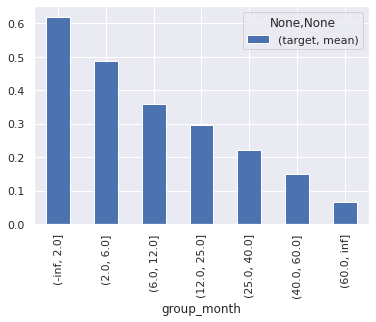

In [48]:
sns.set(font_scale=1)
df['group_month'] = pd.cut(df['lifetime'], [float(-np.inf), 2,6,12,25,40,60,float(np.inf)])
df.groupby('group_month')[['target']].\
    agg(['mean']).plot(kind = "bar")

<AxesSubplot:xlabel='group_month'>

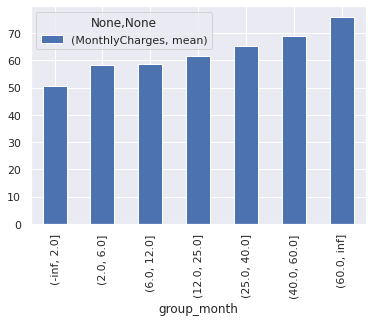

In [49]:

df.groupby('group_month')[[ 'MonthlyCharges']].\
    agg(['mean']).plot(kind = "bar")

Из графиков видно, что чем больше клиенты пользуется услугами, то тем он реже уходит и больше платит.

Удалим временный столбец

In [50]:
df = df.drop( ['group_month', 'group_charges'], axis = 1)

Представим категориальные признаки в пригодном для машинного обучения виде. 

In [51]:
df_dummy = pd.get_dummies(df, drop_first = True)
df_dummy

,MonthlyCharges,TotalCharges,SeniorCitizen,target,lifetime,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,TechSupport_Yes,StreamingTV_No_used,StreamingTV_Yes,StreamingMovies_No_used,StreamingMovies_Yes,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_No_used,MultipleLines_Yes
0,29.85,29.85,0,False,1.018501,0,0,1,0,1,...,0,0,0,0,0,0,1,0,1,0
1,56.95,1889.50,0,False,34.037660,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,53.85,108.15,0,True,2.004148,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,42.30,1840.75,0,False,45.044046,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
4,70.70,151.65,0,True,2.004148,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,84.80,1990.50,0,False,23.984065,1,0,1,0,0,...,1,0,1,0,1,1,1,1,0,1
7039,103.20,7362.90,0,False,71.985051,1,0,1,1,0,...,0,0,1,0,1,0,1,1,0,1
7040,29.60,346.45,0,False,11.072096,0,0,1,0,1,...,0,0,0,0,0,0,1,1,1,0
7041,74.40,306.60,1,True,4.041151,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,1


## Обучение модели:

### Тестируем dummy кодирование 

In [52]:
X = df_dummy.drop(['target'], axis = 1)
y = df_dummy['target']

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.25, random_state=RND)


**Масштабирование признаков**

In [53]:
numerics = ['MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
X_train[numerics] = scaler.fit_transform(X_train[numerics]) 
X_test[numerics] = scaler.transform(X_test[numerics]) 

In [54]:
def best_threshold(y_test, predicted):
    t = np.arange(0.2, 0.8, 0.01)
    best_th = 0 
    f1_best = 0
    for i in t:
        f1 = f1_score(y_test, predicted > i) 
        if f1_best < f1:
            f1_best = f1 
            best_th = i
    return best_th
 

def print_report (y_test, predicted):
    print('roc_auc_score ',round(roc_auc_score(y_test, predicted),4))
    print()
    best_th = best_threshold(y_test, predicted)
    print(classification_report(y_test, predicted > best_th, target_names=["In", "Out"])) 

    


#### LogisticRegression

In [55]:
model_log = LogisticRegression(random_state=12345) 
model_log.fit(X_train, y_train) # обучите модель на тренировочной выборке
predicted_log = model_log.predict(X_test) # получите метрику качества модели на валидационной выборке



In [56]:
print_report(y_test, predicted_log)

roc_auc_score  0.7301

              precision    recall  f1-score   support

          In       0.85      0.90      0.87      1293
         Out       0.67      0.56      0.61       465

    accuracy                           0.81      1758
   macro avg       0.76      0.73      0.74      1758
weighted avg       0.80      0.81      0.80      1758



Как и для большинства других задач, логистическая регрессия не показала хороших результатов. Можно попытаться оптимизировать работу истиматора за счет подбора гиперпараметров и порога, но вряд ли данное улучшение позволит получить roc_auc_score равного 0.9.  

#### CatBoostRegressor

In [57]:
model_cat = CatBoostClassifier(random_seed = RND)
model_cat.fit(X_train, y_train)
predicted_cat = model_cat.predict_proba(X_test)


Learning rate set to 0.020955
0:	learn: 0.6801684	total: 54.2ms	remaining: 54.1s
1:	learn: 0.6661259	total: 59ms	remaining: 29.5s
2:	learn: 0.6548893	total: 63.2ms	remaining: 21s
3:	learn: 0.6407824	total: 67.2ms	remaining: 16.7s
4:	learn: 0.6294830	total: 71.5ms	remaining: 14.2s
5:	learn: 0.6187094	total: 75.3ms	remaining: 12.5s
6:	learn: 0.6085217	total: 79.2ms	remaining: 11.2s
7:	learn: 0.5987015	total: 83.1ms	remaining: 10.3s
8:	learn: 0.5881592	total: 87.5ms	remaining: 9.63s
9:	learn: 0.5797005	total: 92.1ms	remaining: 9.12s
10:	learn: 0.5719459	total: 96.3ms	remaining: 8.66s
11:	learn: 0.5644137	total: 101ms	remaining: 8.29s
12:	learn: 0.5580930	total: 105ms	remaining: 7.97s
13:	learn: 0.5513538	total: 109ms	remaining: 7.68s
14:	learn: 0.5436108	total: 113ms	remaining: 7.43s
15:	learn: 0.5371074	total: 119ms	remaining: 7.33s
16:	learn: 0.5317931	total: 123ms	remaining: 7.12s
17:	learn: 0.5252825	total: 127ms	remaining: 6.93s
18:	learn: 0.5210490	total: 131ms	remaining: 6.76s
19:	

In [58]:
print_report(y_test, predicted_cat[:,1])

roc_auc_score  0.9081

              precision    recall  f1-score   support

          In       0.91      0.90      0.90      1293
         Out       0.73      0.74      0.74       465

    accuracy                           0.86      1758
   macro avg       0.82      0.82      0.82      1758
weighted avg       0.86      0.86      0.86      1758



#### LGBMClassifier

In [ ]:
model_lgb = lgb.LGBMClassifier(random_state = RND)
model_lgb.fit(X_train, y_train)
predicted_lgb = model_lgb.predict_proba(X_test)

In [58]:
print_report(y_test, predicted_lgb[:,1])

roc_auc_score  0.9

              precision    recall  f1-score   support

          In       0.91      0.87      0.89      1293
         Out       0.68      0.75      0.72       465

    accuracy                           0.84      1758
   macro avg       0.79      0.81      0.80      1758
weighted avg       0.85      0.84      0.84      1758



### Тестируем встроенную функцию cat_features

In [60]:
X = df.drop(['target'], axis = 1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.25, random_state=RND)
model_cat = CatBoostClassifier(cat_features=col_cat, verbose=0, random_seed = RND)
model_cat.fit(X_train, y_train)
predicted_cat = model_cat.predict_proba(X_test)

In [61]:
print_report(y_test, predicted_cat[:,1])

roc_auc_score  0.9011

              precision    recall  f1-score   support

          In       0.90      0.90      0.90      1293
         Out       0.71      0.72      0.72       465

    accuracy                           0.85      1758
   macro avg       0.81      0.81      0.81      1758
weighted avg       0.85      0.85      0.85      1758



Лучшие результаты получины на модели CatBoostClassifier. Попробуем улучшить результаты на основе оптимизации гиперпараметров. 

In [61]:
# cb = CatBoostClassifier(cat_features=col_cat)

# grid = {'learning_rate': [0.01,0.03, 0.1],
#         'depth': [6, 8 ,10]}

# grid_search_result = cb.grid_search(
#     grid,
#     X=X_train,
#     y=y_train,
#     verbose=100,
#     plot=True,
#     random_seed = RND
# )

In [62]:
# grid_search_result['params']

In [63]:
model_cat = CatBoostClassifier(depth=6, l2_leaf_reg=1, learning_rate=0.1, cat_features=col_cat, verbose=0, random_seed = RND)
model_cat.fit(X_train, y_train)
predicted_cat = model_cat.predict_proba(X_test)
print_report(y_test, predicted_cat[:,1])


roc_auc_score  0.9132

              precision    recall  f1-score   support

          In       0.90      0.92      0.91      1293
         Out       0.76      0.73      0.75       465

    accuracy                           0.87      1758
   macro avg       0.83      0.82      0.83      1758
weighted avg       0.87      0.87      0.87      1758



Лучше всего себя показал CatBoostClassifier с подбором гиперпараметров и встроенным методом для работы с категориальными признаками.

In [64]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
predicted_Dummy = dummy_clf.predict_proba(X_test)
print_report(y_test, predicted_Dummy[:,1])

roc_auc_score  0.4908

              precision    recall  f1-score   support

          In       0.73      0.72      0.72      1293
         Out       0.25      0.26      0.26       465

    accuracy                           0.60      1758
   macro avg       0.49      0.49      0.49      1758
weighted avg       0.60      0.60      0.60      1758



Сравнение с примитивным классификатором показал, преимущество разработанного классификатора. 

## Анализ результатов работы моделей.

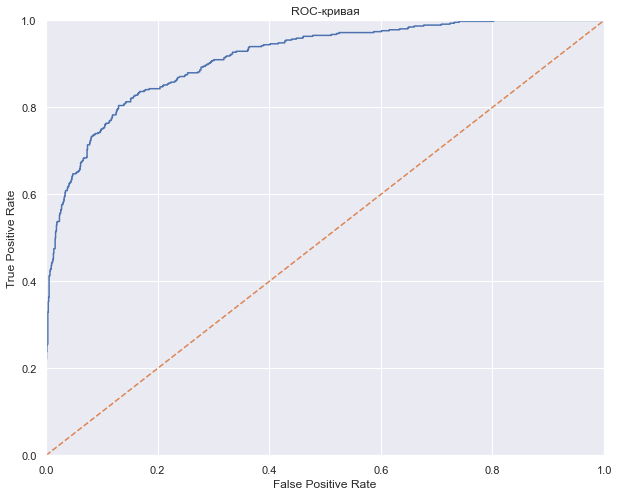

In [65]:
roc_auc_score(y_test, predicted_cat[:,1])
def draw_ROC(target, predict_proba):
    fpr, tpr, thresholds = roc_curve(target, predict_proba[:,1], pos_label=1)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show() 
draw_ROC(y_test, predicted_cat)

In [66]:
(
    pd.DataFrame(model_cat.feature_importances_)
        .assign(feature=X_train.columns)
        .sort_values(by=0, ascending=False)
        .rename({0: 'feature_importance'}, axis=1)
        .reset_index(drop=True)
    [['feature', 'feature_importance']]
)

,feature,feature_importance
0,lifetime,40.102734
1,MonthlyCharges,11.023927
2,TotalCharges,9.663794
3,Type,5.315687
4,PaymentMethod,4.674509
5,MultipleLines,3.900947
6,TechSupport,3.284532
7,OnlineBackup,3.082791
8,OnlineSecurity,3.082512
9,InternetService,2.878961


Наиболее важные характеристики для машинного обучения:
- время пользования услугами; 
- размер ежемесячного платежа;
- тип и способ оплаты. 

## Предложения по использованию модели для решения бизнес-задач

Была построена модель машинного обучения позволяющая определить клиентов, которые могут отказаться от наших услуг. Поэтому в целях повышения лояльности клиентов можно предложить следующие шаги, которые должны быть разработаны совместно с маркетингом: 
- клиентам, которые могут уйти можно предложить либо скидки, либо бесплатный период пользования какой-либо дополнительной услугой;
- необходимо внимательно изучить резкий рост ухода клиентов в районе 70 у.е.
- разработать программу лояльности для клиентов с целью удержать их в первые 12 месяцев, где уход наиболее значимый;
- с целью повышения лояльности клиентов целесообразно предлагать клиентам бесплатные периоды пользования разными услугами;
- клиенты, пользующиеся телефонией гораздо более лояльные, поэтому можно направить усилия на привлечение клиентов, которые пользуются только интернет, чтобы они подключались и к телефонии;
- большое значение для привлечение клиентов имеет годовые или двухгодовые планы, а также автоматическая оплата услуг связи;
- необходимо более подробно изучить почему клиенты с интернетом по оптике чаще уходят, но при этом больше платят, поэтому данные клиенты – очень важны.
